## Controle Quântico Ótimo - Utilização do algoritmo de genético para ajuste do caminho percorrido por uma partícula

Nessa etapa, é necessário avaliar, a partir da equação de Schrödinger com os kets, com o método de Runge-Kutta e com o controle MPC, como a curva de origem ajusta-se a curva de destino. Além disso, é interessantíssimo a avaliação a partir do estado estacionário e ainda verificar como ocorre o ajuste de fases.

Para analisar como o controle melhora o condicionamento da curva através da sua análise futura, esse arquivo estará analisando os ajustes no horizonte 3 e 10. Para melhor coerência dos resultados, a otimização será utilizada para substituir na variável independente da função objetivo e ainda será normalizada para que as comparações tenham o mesmo peso.

Para uma aproximação ótima, utiliza-se um passo de integração (fator do Runge Kutta) com o valor de 0.01, prevendo um milésimo a frente, mas para uma aplicação real a intenção é o aumento dessa fator para uma produção mais real.

Nesse projeto usa-se o algoritmo genético para que seja possível associar o trabalho as áreas de inteligência artificial além de ser mais eficiente do que o gradiente quando compara-se os algoritmos criados manualmente. A criação manual de algoritmos incentiva o entendimento dos processos.

In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp
import cmath

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize
from random import randint, uniform, random

In [3]:
## CONSTANTES

# Considerações: constante de Planck verdadeira: 1, massa: 1

AMOSTRAGEM = 5 #(1/AMOSTRAGEM)
T = 5
PASSO = 0.2 # Para o passo do Runge-Kutta e para T
INICIO_ANALISE = 0.0 # Tempo inicial da analise em um horizonte
FINAL_ANALISE = 0.3 # Tempo final da analise em um horizonte
TAMANHO = 50 # Tempo total de análise



_HORIZONTE = 3
MAX_HORIZONTE = 30 # Uma semana na vida real

ONDA_DESEJADA = [[complex(1/np.sqrt(2),0.0)],[complex(1/np.sqrt(2),0.0)]] # [[c1];[c2]] = [[0.707];[0.707]]

## GENÉTICO

TAM_POP = 50
MIN = 0
MAX = 5
MUTACAO = 0.10
CROSS = 0.70
GERACOES = 100

Abaixo se dão os requisitos básicos para a instauração do teste. Se tem formas de subtrair e somar matrizes, a manipulação das derivadas com o Runge-Kutta além da própria proposta da função objetivo.

In [4]:
# Manipulação das matrizes

def somar(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] + B[i][j]

    return C

def sub(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] - B[i][j]

    return C

In [5]:
## psi' = -i * H * ket{psi}
def dpsidt(t, psi, H): # A derivada da onda em relação ao tempo não tem dependência temporal
    A = np.zeros((2,2), dtype=np.complex_)
    A = np.dot(complex(0,1),H) # i * H
    return -1*np.matmul(A,psi) # - i * H * ket{psi}

# Runge-Kutta de quarta ordem

def rungeKutta(onda, fatorRungeKutta, hamiltoniano, tempoFinal = 2, tempoInicial = 0):
    
        
    k1 = dpsidt(tempoInicial, onda, hamiltoniano)
    k2 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k1)), hamiltoniano)
    k3 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k2)), hamiltoniano)
    k4 = dpsidt(tempoInicial + fatorRungeKutta, somar(onda, np.dot(fatorRungeKutta, k3)), hamiltoniano)
    
    ## y(i+1) = y(i) + h/6*(k1+2*k2+2*k3+k4)
    
    A = somar(np.dot(2,k3), k4)
    B = somar(np.dot(2,k2), k1)
    C = somar(A, B)

    runge = somar(onda,np.dot((fatorRungeKutta / 6.0),(C)))

    return runge

def funcaoObjetivo(x, iteracao, ondaDesejada, hamiltoniano, ondaInicial, horizonteAnalisavel, fatorRungeKutta, tempoAnalise):
    
    avanco = np.zeros((2,1),dtype=np.complex_)
    
    y = 0
    
    horizonte = (horizonteAnalisavel+iteracao)/AMOSTRAGEM
    
    tempo = iteracao/AMOSTRAGEM    
    tempoInicialAnalise = INICIO_ANALISE
    tempoFinalAnalise = FINAL_ANALISE
    
    controles = np.zeros((2,2), dtype=np.complex_)
    controles = [[0, x[0]], [x[0], 0]]
    
    matrizInicial = np.zeros((2,1),dtype=np.complex_)
    matrizInicial = [[ondaInicial[0][0]], [ondaInicial[1][0]]] 

    matrizDesejada = np.zeros((2,1),dtype=np.complex_)
    
    ## Função-Objetivo (Return) = somatorio ||(Matriz_Origem - Matriz_Destino)||^2
    
    ## Avanço temporal
    
    matrizDesejada[0][0] = ondaDesejada[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
    matrizDesejada[1][0] = ondaDesejada[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)

    y += (np.linalg.norm(matrizInicial-matrizDesejada))**2

    avanco = rungeKutta(matrizInicial, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

    matrizInicial = avanco

    tempoInicialAnalise += PASSO
    tempoFinalAnalise += PASSO
    
    for indice in range((iteracao+1), (horizonteAnalisavel+iteracao)):
        tempo = indice/AMOSTRAGEM
        
        matrizDesejada[0][0] = ondaDesejada[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
        matrizDesejada[1][0] = ondaDesejada[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)
        
        y += (np.linalg.norm(matrizInicial-matrizDesejada))**2
        
        controles = [[0, x[int(tempoInicialAnalise*AMOSTRAGEM)]], [x[int(tempoInicialAnalise*AMOSTRAGEM)], 0]]

        avanco = rungeKutta(matrizInicial, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

        matrizInicial = avanco

        tempoInicialAnalise += PASSO
        tempoFinalAnalise += PASSO
    
    return y

Para o funcionamento do MPC, cria-se um looping que consiste em uma otimização não linear, com o apoio da biblioteca de otimização do pyhton, de forma a obter o melhor resultado para o ajuste da curva. Com esse valor em mãos, utiliza-se para os pontos da próxima iteração do método de controle além de efetivar o ajuste realizando o Runge-Kutta com o valor otimizado.

<div align="center">
    <h1>Algoritmo Genético</h1>
</div>

In [6]:
def gerarPopulacao(horizonte):
    populacao = np.zeros((TAM_POP,horizonte))
    for individuo in range(TAM_POP):
        for pos in range(horizonte):
            populacao[individuo,pos] = uniform(MIN, MAX)
    return populacao

In [7]:
def calcularFuncao(populacao, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise):
    valorFuncaoObj = np.zeros(TAM_POP)
    for individuo in range(TAM_POP):
        valorFuncaoObj[individuo] = funcaoObjetivo(populacao[individuo,:], iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    return valorFuncaoObj

In [8]:
def selecao(valorFitness):
    pos = np.random.choice(range(TAM_POP), 2, replace=False)
    valor = valorFitness[pos[0]] < valorFitness[pos[1]]
    if valor == True:
        return pos[0]
    else:
        return pos[1]

In [9]:
def divisaoFitness(valorFuncaoObjetivo):
    divisao = 0
    for i in range(len(valorFuncaoObjetivo)):
        divisao += valorFuncaoObjetivo[i]
    return divisao

def fitness(valorFuncaoObjetivo):
    return valorFuncaoObjetivo/divisaoFitness(valorFuncaoObjetivo)

In [10]:
def cruzamento(pai1, pai2):
    x = random()
    filho1 = x*pai1+(1-x)*pai2
    filho2 = (1-x)*pai1+x*pai2
    return filho1, filho2

In [11]:
def mutacao(individuo, horizonte):
    
    for i in range (0, horizonte):
        if random() < MUTACAO:
            individuo[i] = (1/np.sqrt(2*np.pi))*np.exp((-1/2*(uniform(0, 10)-2)**2))
    
    return individuo

In [12]:
def genetico(horizonte, ondaInicial, iteracao, ondaDesejada, hamiltoniano, fatorRungeKutta, tempoAnalise):

    pop = gerarPopulacao(horizonte)
    fo = calcularFuncao(pop, iteracao, ondaDesejada, hamiltoniano, ondaInicial, horizonte, fatorRungeKutta, tempoAnalise)
    fit = fitness(fo)
    min_fo = min(fit)
    elit = 0
    for k in range(0, len(fit)):
        if min_fo == fit[k]:
            elit = k
    
    melhor_fo = np.zeros(GERACOES)
    for geracao in range(GERACOES):
        new_pop = np.empty((0, horizonte))
        for i in range(round((TAM_POP) / 2)):
            pai1 = 0
            pai2 = 0
            while pai1 == pai2:
                pai1 = selecao(fit)
                pai2 = selecao(fit)
            if random() < CROSS:
                filho1, filho2 = cruzamento(pop[pai1, :], pop[pai2, :])     
                filho1 = mutacao(filho1, horizonte)
                filho2 = mutacao(filho2, horizonte)  
                new_pop = np.vstack([new_pop, filho1, filho2])     
            else:
                pais = np.vstack([mutacao(pop[pai1, :], horizonte), mutacao(pop[pai2, :], horizonte)])
                new_pop = np.vstack([new_pop, pais]) 
                
        fo = calcularFuncao(new_pop, iteracao, ondaDesejada, hamiltoniano, ondaInicial, horizonte, fatorRungeKutta, tempoAnalise)
        fit = fitness(fo)
        min_fo = min(fo)
        max_fo = max(fit)
        pos = 0
        for k in range(0, len(fit)):
            if max_fo == fit[k]:
                pos = k

        new_pop = np.vstack([new_pop, pop[elit]])
        pop = np.delete(new_pop, pos, 0)
        min_fo2 = min(fit)
        
        for k in range(0, len(fit)):
            if min_fo2 == fit[k]:
                elit = k  
        
        melhor_fo[geracao] = min_fo
        pos_min_fo = np.where(fo == min_fo)

    return pop[pos_min_fo,:][0,0]

### Valores de função objetivo

In [13]:
def vfo(valor):
    ts = np.linspace(0, T, TAMANHO) # Tempo em x 

    plt.ylabel('Função Objetivo') 
    plt.xlabel('Tempo') 
    plt.plot(ts, abs(valor[0])/abs(valor[0][0]), color='g', marker='o', linewidth=1, markersize=1, label="Valor da FO")
    plt.legend(loc="upper right")
    plt.show()

### Programa principal

In [14]:
def main(horizonte, ondaInicial):
    
    it = 0
    
    u = [] # Chute inicial -> controladores
    u.append(uniform(-1, 1))
    for l in range(1, horizonte):
        u.append(u[0])
    
    print(len(u))
    # O que deve ser retornado
    minimos = np.zeros((1,TAMANHO), dtype=np.complex_) # Valores da otimização
    valoresFuncaoObjetivo = np.zeros((1,TAMANHO), dtype=np.complex_) # Comparação do valor encontrado com a FO
    constantes = np.zeros((2, TAMANHO), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
    valoresOnda = np.zeros((2, TAMANHO), dtype=np.complex_) # Guarda as variações da Onda Inicial
    
    hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    while it < TAMANHO:
        
        #print(f"Iteração: {iteracao+1}")
        
        # Variação do Psi
        valoresOnda[0][it] = ondaInicial[0][0]
        valoresOnda[1][it] = ondaInicial[1][0]

        # Obtenção das constantes que multiplicam Psi
        # C_0 = Psi_0/[e^(1/2*pi*tempo)] equação 2.18 Griffiths
        constantes[0][it] = ondaInicial[0][0]/np.exp(-1*complex(0,1)*(1/2*np.pi)*it/AMOSTRAGEM)
        constantes[1][it] = ondaInicial[1][0]/np.exp(-1*complex(0,1)*(3/2*np.pi)*it/AMOSTRAGEM)
        
        ## Minimização
    
        resultado = genetico(horizonte, ondaInicial, it, ONDA_DESEJADA, hamiltoniano, PASSO, TAMANHO)

        # Função objetivo

        minimos[0][it] = resultado[0]

        valoresFuncaoObjetivo[0][it] = funcaoObjetivo(resultado, it, ONDA_DESEJADA, hamiltoniano, ondaInicial, horizonte, PASSO, TAMANHO)

        ## Hamiltoniano corntrolado

        controle = np.zeros((2,1), dtype=np.complex_)
        controle = [[0, resultado[0]],[resultado[0], 0]]
        hamiltoniano = somar(hamiltoniano, controle)

        ## Adaptação da onda ao controle

        ondaAvancada = np.zeros((2,2), dtype=np.complex_)
        ondaAvancada = rungeKutta(ondaInicial, PASSO, hamiltoniano, tempoFinal = FINAL_ANALISE, tempoInicial = INICIO_ANALISE)

        ondaInicial[0][0] = ondaAvancada[0][0]
        ondaInicial[1][0] = ondaAvancada[1][0]

        # Reset
        hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

        u = []
        for l in range(0, horizonte):
            u.append(resultado[0])
        
        it += 1
        
    return minimos, valoresFuncaoObjetivo, constantes, valoresOnda

### Avaliação das componentes

Um grande problemas dos métodos de minimização está concentrado no cálculo numérico. O cálculo númerico se trata de um processo de aproximação de forma que quanto pior é a manipulação das variáveis, pior ficará a aproximação. Nesse sistema se torna perceptível a melhoria do ajuste através da desafagem de uma curva em relação a outra.

Conforme o livro, introdução à computação clássica e quântica de Thomas Wong (2022), a defasagem apresentada por um sistema quântico não tem significado físico se for a mesma para todo o sistema, ou seja, todas as componentes devem ter a mesma diferença de fases. Para realizar essa avaliação, se faz necessário propor uma diferença entre a curva original e o destino, tanto na primeira componente quanto na segunda, além de realizar a diferença entre essas partes.

In [15]:
def evolucaoDesejada():
    evolucaoDesejada = np.zeros((2,TAMANHO), dtype=np.complex_)
    for i in range(0, TAMANHO):
        evolucaoDesejada[0][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/AMOSTRAGEM))
        evolucaoDesejada[1][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/AMOSTRAGEM))
        
    return evolucaoDesejada

In [16]:
def evolucaoPrimeiraComponente(valoresOnda, evolucaoDesejada):
    ts = np.linspace(0, T, TAMANHO)

    realInicialPrimeiraComponente = [elemento.real for elemento in valoresOnda[0]] 
    imaginarioInicialPrimeiraComponente = [elemento.imag for elemento in valoresOnda[0]] 

    realDesejadoPrimeiraComponente = [elemento.real for elemento in evolucaoDesejada[0]] 
    imaginarioDesejadoPrimeiraComponente = [elemento.imag for elemento in evolucaoDesejada[0]] 

    # Plotagem
    plt.subplot(2,1,1)

    plt.ylabel('Real') 
    plt.xlabel('Tempo') 
    plt.title('Primeira componente -> real')
    plt.plot(ts, realInicialPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Inicial")
    plt.plot(ts, realDesejadoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Desejado")
    plt.legend(loc='upper right')

    plt.subplot(2,1,2)

    plt.ylabel('Imaginário') 
    plt.xlabel('Tempo') 
    plt.title('Primeira componente -> imaginária')
    plt.plot(ts, imaginarioInicialPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Inicial")
    plt.plot(ts, imaginarioDesejadoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Desejado")
    plt.legend(loc='upper right')

    plt.tight_layout()

In [17]:
def evolucaoSegundaComponente(valoresOnda, evolucaoDesejada):
    ts = np.linspace(0, T, TAMANHO)

    realInicialSegundaComponente = [elemento.real for elemento in valoresOnda[1]] 
    imaginarioInicialSegundaComponente = [elemento.imag for elemento in valoresOnda[1]] 

    realDesejadoSegundaComponente = [elemento.real for elemento in evolucaoDesejada[1]] 
    imaginarioDesejadoSegundaComponente = [elemento.imag for elemento in evolucaoDesejada[1]] 

    # Plotagem
    plt.subplot(2,1,1)

    plt.ylabel('Real') 
    plt.xlabel('Tempo') 
    plt.title('Segunda componente -> real')
    plt.plot(ts, realInicialSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Inicial")
    plt.plot(ts, realDesejadoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Desejado")
    plt.legend(loc='upper right')

    plt.subplot(2,1,2)

    plt.ylabel('Imaginário') 
    plt.xlabel('Tempo') 
    plt.title('Segunda componente -> imaginária')
    plt.plot(ts, imaginarioInicialSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Inicial")
    plt.plot(ts, imaginarioDesejadoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Desejado")
    plt.legend(loc='upper right')

    plt.tight_layout()

### Gráficos - Avaliação da densidade de probabilidade para encontrar uma partícula no ponto x

Conforme descrito durante os capítulos 1, 2 e 3 do livro Mecânica Quântica por David Griffths, a estatística é um dos principais pontos para o entendimento da mecânica quântica, dessa forma é interessante entender qual é a probabilidade de uma partícula estar em um determinado lugar em um certo tempo e para tal se define:$$\int |\Psi(x,t)|^{2}dx = 1$$ Ainda nessa perspectiva, foi definido que o resultado da equação de Schrödinger pode ser definido a partir da escolha do potêncial V(x,t) e ainda que os enumeros resultados podem formar outros por meio de uma combinação linear de forma que o conjunto do quadrado das constantes que o formam, em sua soma resultam em 1. Isso define a probabilidade de um estado. Para este estudo considerou-se dois estados: $$1\psi_0(x,t)+0\psi_1(x,t)$$ de forma que para o primeiro estado a probabilidade é de 64% enquanto para o segundo é de 36%.

Se torna claro que a probabilidade total deve ser 1 e definindo o produto interno como $\int |\Psi(x,t)|^{2}dx = <\Psi | \Psi> = 1 = \sum_n |c_n|²$ podemos verificar se o ajuste da pesquisa está correto avaliando as constantes que são alteradas conforme o tempo de acordo com o gráfico apresentado acima.

In [18]:
def probabilidade(constantes):
    dp = []
    for i in range(0, TAMANHO):
        dp.append((abs(constantes[0][i])**2+abs(constantes[1][i])**2))

    plt.ylabel('Densidade probabilidade') 
    plt.xlabel('Tempo') 
    plt.plot(ts, dp, color='r', marker='*', linewidth=1, markersize=1, label="Valor do somatório das constantes")
    plt.legend(loc="upper right")
    plt.show()

### Variação dos horizontes

Como será observado a frente, a variação dos horizontes auxiliam na melhoria da defasagem apresentada pelo sistema, no entanto isso gera complicações no custo computacional.

In [19]:
desejo = evolucaoDesejada()

ondaInicial = [[complex(1.00,0.0)],[complex(0.00,0.0)]] # [[c1];[c2]] = [[1.0];[0.0]]

minimos, valoresFuncaoObjetivo, constantes, valoresOnda = main(3, ondaInicial)

3


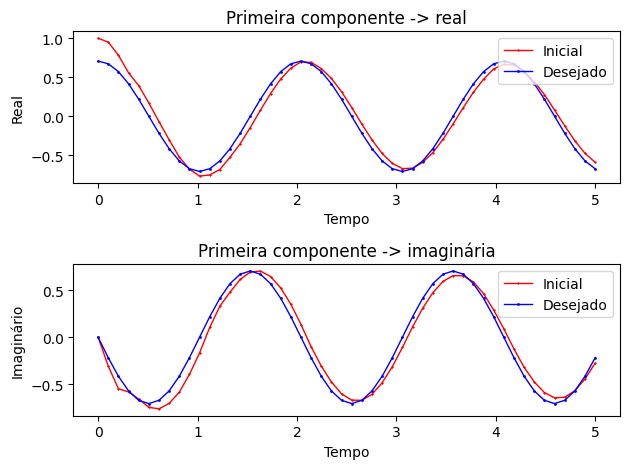

In [20]:
evolucaoPrimeiraComponente(valoresOnda, desejo)

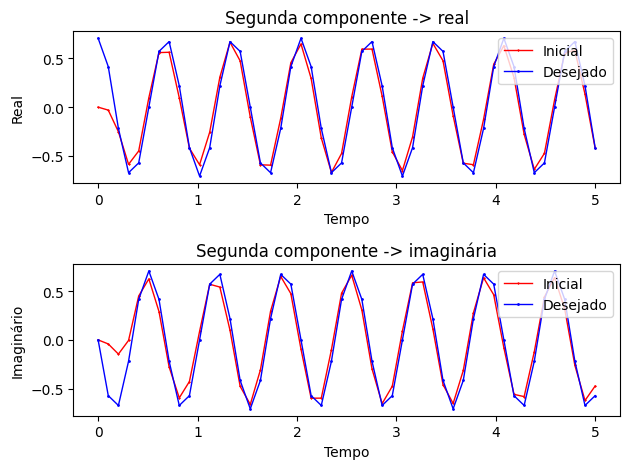

In [21]:
evolucaoSegundaComponente(valoresOnda, desejo)

In [22]:
ondaInicial = [[complex(1.00,0.0)],[complex(0.00,0.0)]] # [[c1];[c2]] = [[1.0];[0.0]]

minimos, valoresFuncaoObjetivo, constantes, valoresOnda = main(10, ondaInicial)

10


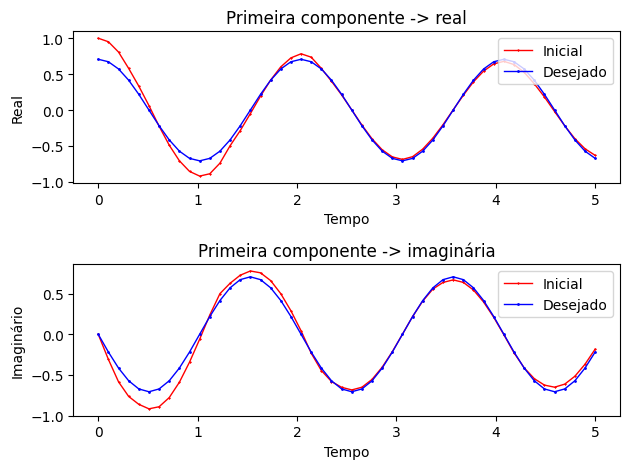

In [23]:
evolucaoPrimeiraComponente(valoresOnda, desejo)

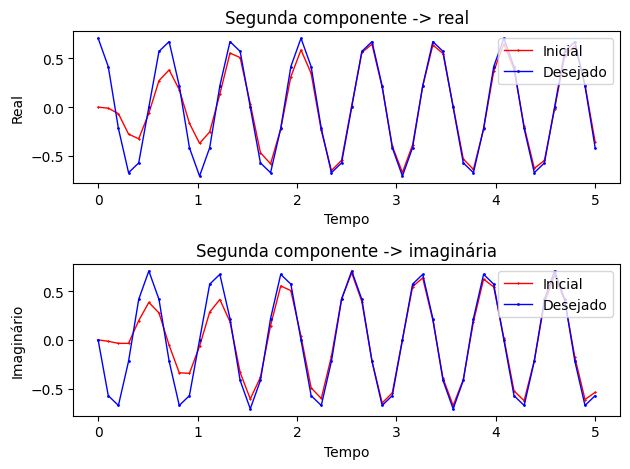

In [24]:
evolucaoSegundaComponente(valoresOnda, desejo)

### Valores de erro e defasagem

Ambos os valores são importantes para entender a atuação do horizonte no sistema. É desejado que com o aumento do horizonte, a distância entre os picos (defasagem), além da distância entre as curvas (erro), sofram uma diminuição e ainda um aumento de custo computacional. Para realizar essa tarefa, consideremos um valor máximo de horizonte e um mínimo. Através deles realizaremos um looping que chamará a função principal alterando o horizonte linearmente e armazenando os valores de defasagem e de erro em vetores separados a fim de plotar posteriormente.

In [25]:
def ED(desejo):
    
    erro = []
    defasagem = []
    itae = []
    ise = []
    
    ts = np.linspace(0, T, TAMANHO)
    
    i = MIN_HORIZONTE
    
    while i <= MAX_HORIZONTE:
        
        print(f"Horizonte: {i}")
        
        av1 = []
        av2 = []
        
        ondaInicial = [[complex(1.00,0.0)],[complex(0.00,0.0)]] # [[c1];[c2]] = [[1.0];[0.0]]
        minimos, valoresFuncaoObjetivo, constantes, valoresOnda = main(i, ondaInicial)
        
        d = cmath.polar(valoresOnda[0][TAMANHO-1]/desejo[0][TAMANHO-1])[1]
        defasagem.append(d);
        e = np.linalg.norm(valoresOnda-desejo)/i
        erro.append(e)
        
        for k in range(0, TAMANHO): 
            av1.append(k/AMOSTRAGEM*(np.linalg.norm(valoresOnda[0][k]-desejo[0][k])/i)*PASSO)
            av2.append((np.linalg.norm(valoresOnda[0][k]-desejo[0][k])/i)**2*PASSO)

        plt.ylabel('Valor da Integral') 
        plt.xlabel('Tempo') 
        plt.title('Avaliação dos erros')
        
        plt.plot(ts, av1, color='r', marker='*', linewidth=1, markersize=1, label="ITAE")
        plt.plot(ts, av2, color='b', marker='*', linewidth=1, markersize=1, label="ISE")
        plt.legend(loc='upper right')

        plt.show()
        
        print(f"Defasagem: {d}")
        print(f"Erro: {e}")
        print(f"ITAE: {sum(av1)}")
        print(f"ISE: {sum(av2)}")
        print("-------------------")
        
        if i >= 10:
            i+=10
        else:
            i+=1
        
    return defasagem, erro, itae, ise

In [26]:
def plot(array):
    ts = []
    
    j = MIN_HORIZONTE
    while j <= MAX_HORIZONTE:
        ts.append(j)
        if j >= 10:
            j+=10
        else:
            j+=1
        
    plt.plot(ts, array)
    plt.show()

In [27]:
defasagem, erro, itae, ise = ED(desejo)

plot(erro)

NameError: name 'MIN_HORIZONTE' is not defined

In [ ]:
plot(defasagem)